# Problem Statement


Please refer to the following link for the problem statement.

https://datahack.analyticsvidhya.com/contest/job-a-thon-2/?utm_source=datahack&utm_medium=Navbar&utm_campaign=Jobathon#LeaderBoard

### Methodology:

- Data exploring and understanding: This step involves preliminary level data understanding and exploring.

- Data Cleaning: This step includes cleaning the existing data. We check the data for any missing values and treat them as per the requirements. We also need to look for constant value columns as that is not going to add any additional value to out analysis. Sometimes columns with very high proportion of any particular value also doesn't add any values. Hence, getting rid of them helps with further analysis.

- Data Preparation: This step is mainly useful for feeding in the data into the model. It involves steps like creating dummy variables, scaling etc. depending upon the data type.

- Train-test split: This step involves splitting the dataset into train and test parts.

- Model Development-validation and evaluation: This steps involves training the model and validate it. It involves evaluating the model using relevant metrics. Here, we would be training multiple models and try to make effective ensemble out of it.

- Conclusion/Recommendation: It involves drawing conclusions and recommendations to business.

In [1]:
pip install catboost

In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score, accuracy_score, roc_auc_score, plot_roc_curve
from sklearn.preprocessing import MinMaxScaler

from catboost import CatBoostClassifier

from lightgbm import LGBMClassifier

from itertools import combinations

## 1. Data exploring, understanding, and preparing

In [3]:
# Mounting google drive

from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [4]:
# Reading train dataset 

data = pd.read_csv('/content/gdrive/MyDrive/AV/train_s3TEQDk.csv')

data_t = pd.read_csv('/content/gdrive/MyDrive/AV/test_mSzZ8RL.csv') ###### Please entre your new test data here!

data.head()

,ID,Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active,Is_Lead
0,NNVBBKZB,Female,73,RG268,Other,X3,43,No,1045696,No,0
1,IDD62UNG,Female,30,RG277,Salaried,X1,32,No,581988,No,0
2,HD3DSEMC,Female,56,RG268,Self_Employed,X3,26,No,1484315,Yes,0
3,BF3NC7KV,Male,34,RG270,Salaried,X1,19,No,470454,No,0
4,TEASRWXV,Female,30,RG282,Salaried,X1,33,No,886787,No,0


In [5]:
data.shape

(245725, 11)

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 245725 entries, 0 to 245724
Data columns (total 11 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   ID                   245725 non-null  object
 1   Gender               245725 non-null  object
 2   Age                  245725 non-null  int64 
 3   Region_Code          245725 non-null  object
 4   Occupation           245725 non-null  object
 5   Channel_Code         245725 non-null  object
 6   Vintage              245725 non-null  int64 
 7   Credit_Product       216400 non-null  object
 8   Avg_Account_Balance  245725 non-null  int64 
 9   Is_Active            245725 non-null  object
 10  Is_Lead              245725 non-null  int64 
dtypes: int64(4), object(7)
memory usage: 20.6+ MB


Data is having 10 feature columns and 1 output variable column. `Credit_Product` column is having few null entries.

### 1. ID

In [7]:
data.ID.nunique()

245725

It is having all unique values which indicates serialized entries. Hence, we would drop it.

In [8]:
data = data.drop('ID', axis=1)
data.head()

,Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active,Is_Lead
0,Female,73,RG268,Other,X3,43,No,1045696,No,0
1,Female,30,RG277,Salaried,X1,32,No,581988,No,0
2,Female,56,RG268,Self_Employed,X3,26,No,1484315,Yes,0
3,Male,34,RG270,Salaried,X1,19,No,470454,No,0
4,Female,30,RG282,Salaried,X1,33,No,886787,No,0


### 2. Gender

In [9]:
data.Gender.value_counts(dropna = False)

Male      134197
Female    111528
Name: Gender, dtype: int64

In [10]:
pd.crosstab(index = data.Gender,
            columns = data.Is_Lead,
            normalize='index')

Is_Lead,0,1
Gender,,
Female,0.796419,0.203581
Male,0.734845,0.265155


The data distribution amongst males/female Vs output variable is quite similar. 

### 3. Age

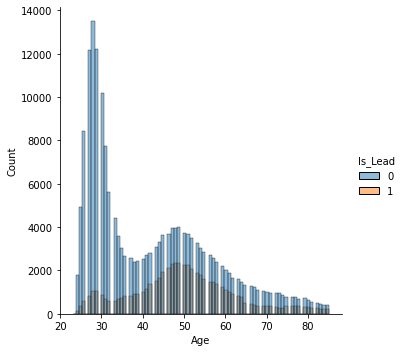

In [11]:
sns.displot(data = data, x= 'Age', hue="Is_Lead", kind="hist")

We can observed some changes in `Is_Lead` rate after around age 35. Hence, we would try to bin this column and generate one more feature column named `Age1`.

In [12]:
data['Age1'] = data['Age'].apply(lambda x: 'age1' if x<=35 else 'age2')

pd.crosstab(index = data.Age1,
            columns = data.Is_Lead,
            normalize='index')

Is_Lead,0,1
Age1,,
age1,0.915225,0.084775
age2,0.665377,0.334623


### 4. Region_Code

In [13]:
data.Region_Code.nunique()

35

In [14]:
data.Region_Code.value_counts(dropna = False)

RG268    35934
RG283    29416
RG254    26840
RG284    19320
RG277    12826
RG280    12775
RG269     7863
RG270     7720
RG261     7633
RG257     6101
RG251     5950
RG282     5829
RG274     5286
RG272     5252
RG281     5093
RG273     4497
RG252     4286
RG279     3976
RG263     3687
RG275     3245
RG260     3110
RG256     2847
RG264     2793
RG276     2764
RG259     2586
RG250     2496
RG255     2018
RG258     1951
RG253     1858
RG278     1822
RG262     1788
RG266     1578
RG265     1546
RG271     1542
RG267     1497
Name: Region_Code, dtype: int64

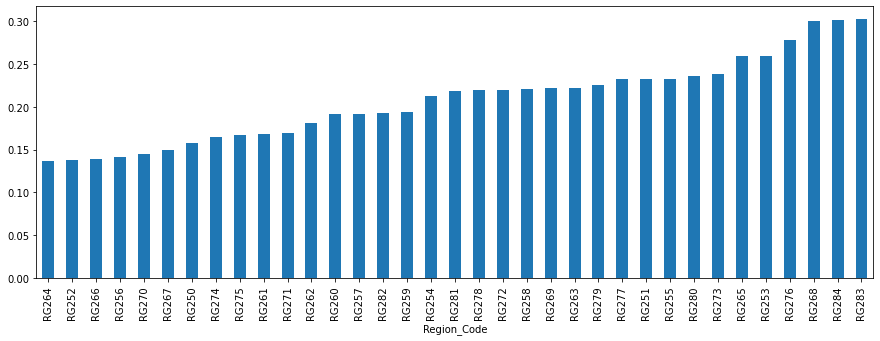

In [15]:
plt.subplots(figsize=(15,5))
pd.crosstab(index = data.Region_Code,
            columns = data.Is_Lead,
            normalize='index').sort_values(1)[1].plot.bar()

We can observed a little jump in the lead rate after `RG259` value. Hence, we would try to bin this into two parts and create one more feature named `Region_Code1`.

In [16]:
rc_tab = pd.crosstab(index = data.Region_Code,
            columns = data.Is_Lead,
            normalize='index')

rc1 = []
rc2 = []


for i in range(rc_tab.shape[0]):
    if rc_tab[1][i]<=rc_tab.loc['RG259', 1]:
        rc1.append(rc_tab.index[i])
    else:
        rc2.append(rc_tab.index[i])



data['Region_Code1'] = data['Region_Code'].apply(lambda x: 'rc1' if x in rc1 else 'rc2')

pd.crosstab(index = data.Region_Code1,
            columns = data.Is_Lead,
            normalize='index')

Is_Lead,0,1
Region_Code1,,
rc1,0.834397,0.165603
rc2,0.739487,0.260513


### 5. Occupation

In [17]:
data.Occupation.value_counts(dropna = False)

Self_Employed    100886
Salaried          71999
Other             70173
Entrepreneur       2667
Name: Occupation, dtype: int64

In [18]:
pd.crosstab(index = data.Occupation,
            columns = data.Is_Lead,
            normalize='index')

Is_Lead,0,1
Occupation,,
Entrepreneur,0.339333,0.660667
Other,0.755048,0.244952
Salaried,0.840331,0.159669
Self_Employed,0.724035,0.275965


We can observed `Entrepreneur` is having higher lead rate as compared to other categories hence we would be binning it into two and create one new derived feature column `if_ent`. 

In [19]:
# if_ent

data['if_ent'] = data['Occupation'].apply(lambda x: 1 if x=='Entrepreneur' else 0)

pd.crosstab(index = data.if_ent,
            columns = data.Is_Lead,
           normalize = 'index')

Is_Lead,0,1
if_ent,,
0,0.767438,0.232562
1,0.339333,0.660667


### 6. Channel_Code

In [20]:
data.Channel_Code.value_counts(dropna = False)

X1    103718
X3     68712
X2     67726
X4      5569
Name: Channel_Code, dtype: int64

In [21]:
pd.crosstab(index = data.Channel_Code,
            columns = data.Is_Lead,
            normalize='index')

Is_Lead,0,1
Channel_Code,,
X1,0.908579,0.091421
X2,0.672105,0.327895
X3,0.632975,0.367025
X4,0.752200,0.247800


It can be observed that `X1` is having higher lead rate. Hence, we would be deriving one more column `if_X`. 

In [22]:
# if_X1

data['if_X1'] = data['Channel_Code'].apply(lambda x: 1 if x=='X1' else 0)

pd.crosstab(index = data.if_X1,
            columns = data.Is_Lead,
           normalize = 'index')

Is_Lead,0,1
if_X1,,
0,0.656313,0.343687
1,0.908579,0.091421


### 7. Vintage

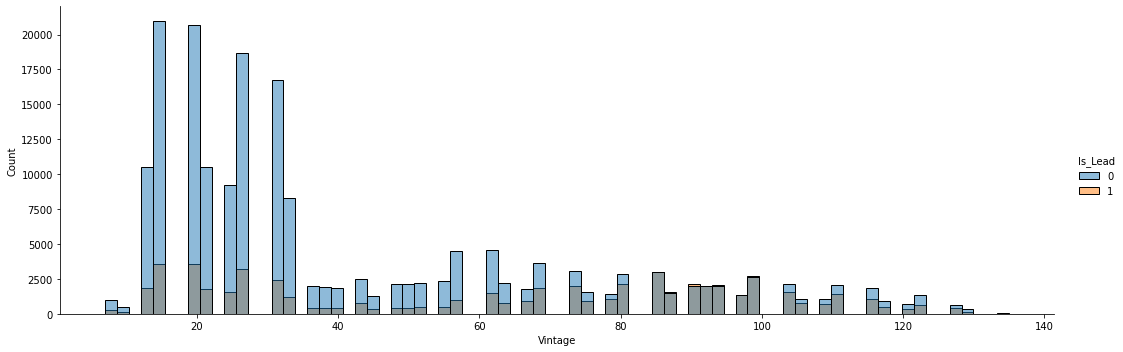

In [23]:
sns.displot(data = data, x = 'Vintage', hue = 'Is_Lead', kind="hist", height=5, aspect=3)

Above plot indicates that there it some change in lead rate after Vintage of 60. We would be deriving one more column named `Vintage1` based on that.

In [24]:
data['Vintage1'] = data['Vintage'].apply(lambda x: 'vt1' if x<=60 else 'vt2')

pd.crosstab(index = data.Vintage1,
            columns = data.Is_Lead,
            normalize='index')

Is_Lead,0,1
Vintage1,,
vt1,0.849669,0.150331
vt2,0.586488,0.413512


### 8. Credit_Product

In [25]:
data.Credit_Product.value_counts(dropna = False)

No     144357
Yes     72043
NaN     29325
Name: Credit_Product, dtype: int64

We can see there are some null entries in this column. Lets check if lead rate corresponding to null entries is similar to `No` or `Yes` categorized data.

In [26]:
# null entry data
data[data.Credit_Product.isna()]

,Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active,Is_Lead,Age1,Region_Code1,if_ent,if_X1,Vintage1
6,Male,62,RG282,Other,X3,20,NaN,1056750,Yes,1,age2,rc1,0,0,vt1
15,Male,33,RG268,Self_Employed,X2,69,NaN,517063,Yes,1,age1,rc2,0,0,vt2
31,Female,32,RG279,Salaried,X4,15,NaN,1072850,Yes,1,age1,rc2,0,0,vt1
36,Female,41,RG268,Self_Employed,X3,62,NaN,962383,No,1,age2,rc2,0,0,vt2
40,Female,63,RG254,Other,X3,103,NaN,1249319,Yes,1,age2,rc2,0,0,vt2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245684,Female,51,RG281,Entrepreneur,X3,99,NaN,552992,No,1,age2,rc2,1,0,vt2
245694,Female,50,RG277,Self_Employed,X2,92,NaN,1385124,No,1,age2,rc2,0,0,vt2
245699,Male,53,RG254,Other,X2,19,NaN,1141825,Yes,1,age2,rc2,0,0,vt1
245714,Female,46,RG268,Self_Employed,X2,19,NaN,993195,No,1,age2,rc2,0,0,vt1


In [27]:
# Lead rate for null entries
data[data.Credit_Product.isna()].Is_Lead.mean()

0.8516624040920716

In [28]:
# Lead rate for 'No' entries
data[data.Credit_Product == 'Yes'].Is_Lead.mean()

0.3149507932762378

In [29]:
# Lead rate for 'Yes' entries
data[data.Credit_Product == 'No'].Is_Lead.mean()

0.07358839543631414

All three of them have very different lead rate. Hence, we would be filling null entries with `No_data` value.

In [30]:
# filling null entries

data['Credit_Product'] = data['Credit_Product'].fillna('No_data')

In [31]:
pd.crosstab(index = data.Credit_Product,
            columns = data.Is_Lead,
            normalize='index')

Is_Lead,0,1
Credit_Product,,
No,0.926412,0.073588
No_data,0.148338,0.851662
Yes,0.685049,0.314951


### 9. Avg_Account_Balance

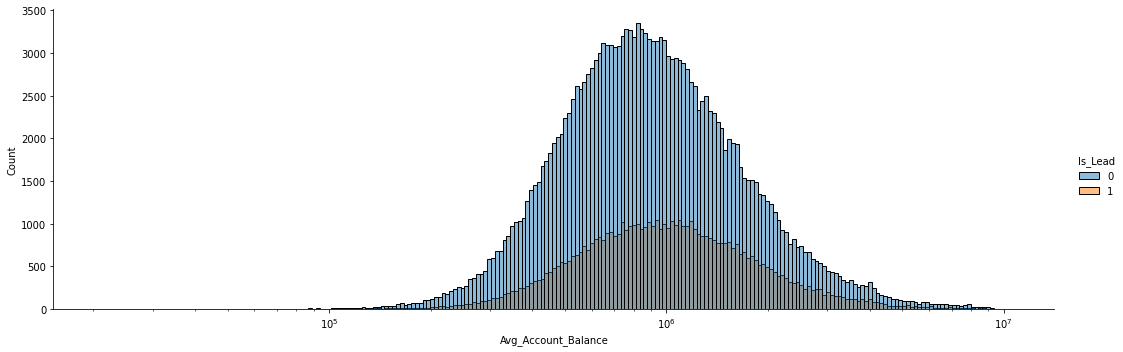

In [32]:
sns.displot(data = data, x = 'Avg_Account_Balance', hue = 'Is_Lead',
            kind="hist", height=5, aspect=3, log_scale=True)

We can not observe much of the trend difference here with respect to Avg_Account_Balance value. Lets try to bin it with respect to quartiles.

In [33]:
q1 = data['Avg_Account_Balance'].describe().loc['25%']
q2 = data['Avg_Account_Balance'].describe().loc['50%']
q3 = data['Avg_Account_Balance'].describe().loc['75%']

In [34]:
data['Avg_Account_Balance1'] = data['Avg_Account_Balance'].apply(lambda x: 'ab1' if x<=q1 else 'ab2' if q1<x<=q2 else 'ab3' if q2<x<=q3 else 'ab4')

pd.crosstab(index = data.Avg_Account_Balance1,
            columns = data.Is_Lead,
           normalize = 'index')

Is_Lead,0,1
Avg_Account_Balance1,,
ab1,0.808442,0.191558
ab2,0.774383,0.225617
ab3,0.746345,0.253655
ab4,0.721993,0.278007


We can see there is some different in lead rate amongst all the quartile based bins. Hence, we would be keeping the column `Avg_Account_Balance1`. 

### 10. Is_Active

In [35]:
data.Is_Active.value_counts(dropna = False)

No     150290
Yes     95435
Name: Is_Active, dtype: int64

In [36]:
pd.crosstab(index = data.Is_Active,
            columns = data.Is_Lead,
            normalize='index')

Is_Lead,0,1
Is_Active,,
No,0.791849,0.208151
Yes,0.717033,0.282967


We can observed there is slight change in lead rate with respect to Is_Active.

### 11. Is_Lead

In [37]:
data.Is_Lead.value_counts(dropna = False)

0    187437
1     58288
Name: Is_Lead, dtype: int64

we can observe that data is having 1:3 ratio for lead rate, which makes our data healthy enough for using classification algorithms.

Now lets try to do bi-variate comparison and check if we can derive more feature columns.

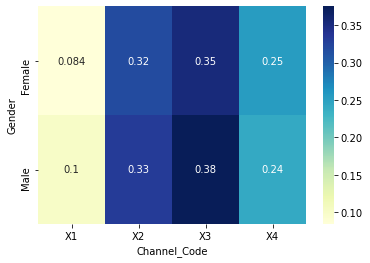

In [38]:
sns.heatmap(pd.crosstab(index = data.Gender, columns =data.Channel_Code, values = data.Is_Lead,  aggfunc='mean'),
           annot = True,
           cmap = 'YlGnBu')

We can observe that female with X1 channel have least lead rate. We can derive feature based on that. (`x1_female`)

In [39]:
# female + X1
x1_female = []

for i in range(data.shape[0]):
  if (data.Channel_Code[i]=='X1') and (data.Gender[i]=='Female'):
    x1_female.append(1)
  else:
    x1_female.append(0)


data['x1_female'] = x1_female

pd.crosstab(index = data.x1_female,
            columns = data.Is_Lead,
           normalize = 'index')

Is_Lead,0,1
x1_female,,
0,0.715317,0.284683
1,0.915709,0.084291


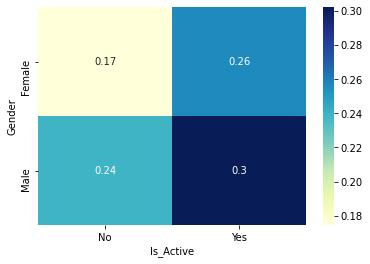

In [40]:
sns.heatmap(pd.crosstab(index = data.Gender, columns =data.Is_Active, values = data.Is_Lead,  aggfunc='mean'),
           annot = True,
           cmap = 'YlGnBu')

We can observe that female with no activity have least lead rate. We can derive feature based on that. (`ia_female`)

In [41]:
# female + inactive
ia_female = []

for i in range(data.shape[0]):
  if (data.Is_Active[i]=='No') and (data.Gender[i]=='Female'):
    ia_female.append(1)
  else:
    ia_female.append(0)


data['ia_female'] = ia_female

pd.crosstab(index = data.ia_female,
            columns = data.Is_Lead,
           normalize = 'index')

Is_Lead,0,1
ia_female,,
0,0.736873,0.263127
1,0.825280,0.174720


In [42]:
data['bal_b_age'] = data['Avg_Account_Balance']/data['Age']

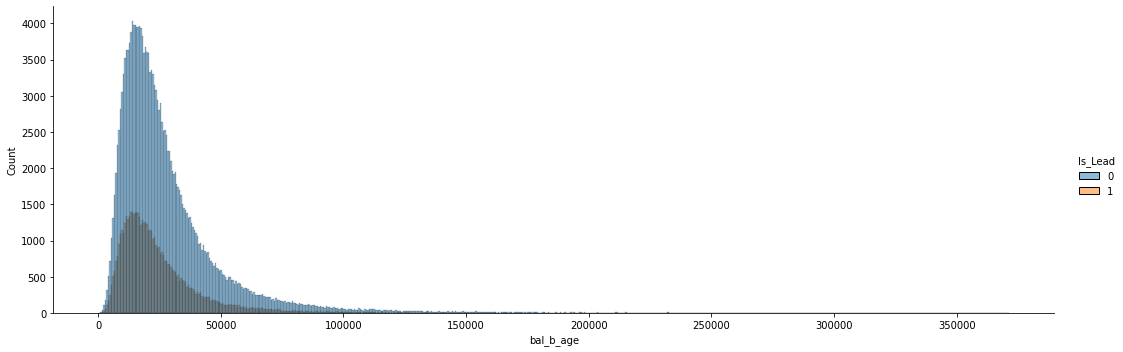

In [43]:
sns.displot(x = 'bal_b_age', 
            hue='Is_Lead',
            data = data,
            kind="hist", height=5, aspect=3)

In [44]:
data.head()

,Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active,Is_Lead,Age1,Region_Code1,if_ent,if_X1,Vintage1,Avg_Account_Balance1,x1_female,ia_female,bal_b_age
0,Female,73,RG268,Other,X3,43,No,1045696,No,0,age2,rc2,0,0,vt1,ab3,0,1,14324.602740
1,Female,30,RG277,Salaried,X1,32,No,581988,No,0,age1,rc2,0,1,vt1,ab1,1,1,19399.600000
2,Female,56,RG268,Self_Employed,X3,26,No,1484315,Yes,0,age2,rc2,0,0,vt1,ab4,0,0,26505.625000
3,Male,34,RG270,Salaried,X1,19,No,470454,No,0,age1,rc1,0,1,vt1,ab1,0,0,13836.882353
4,Female,30,RG282,Salaried,X1,33,No,886787,No,0,age1,rc1,0,1,vt1,ab2,1,1,29559.566667


In [45]:
cat_cols0 = data.select_dtypes('object').columns
print(cat_cols0)

num_cols0 = data.select_dtypes(['int64','float64']).columns
print(num_cols0)

Index(['Gender', 'Region_Code', 'Occupation', 'Channel_Code', 'Credit_Product',
       'Is_Active', 'Age1', 'Region_Code1', 'Vintage1',
       'Avg_Account_Balance1'],
      dtype='object')
Index(['Age', 'Vintage', 'Avg_Account_Balance', 'Is_Lead', 'if_ent', 'if_X1',
       'x1_female', 'ia_female', 'bal_b_age'],
      dtype='object')


In [46]:
# Reading test dataset and preparing it as per train set

data_t['Credit_Product'] = data_t['Credit_Product'].fillna('No_data')
data_t['Age1'] = data_t['Age'].apply(lambda x: 'age1' if x<=35 else 'age2')
data_t['Region_Code1'] = data_t['Region_Code'].apply(lambda x: 'rc1' if x in rc1 else 'rc2')
data_t['Vintage1'] = data_t['Vintage'].apply(lambda x: 'vt1' if x<=60 else 'vt2')
data_t['Avg_Account_Balance1'] = data_t['Avg_Account_Balance'].apply(lambda x: 'ab1' if x<=q1 else 'ab2' if q1<x<=q2 else 'ab3' if q2<x<=q3 else 'ab4')
data_t['if_ent'] = data_t['Occupation'].apply(lambda x: 1 if x=='Entrepreneur' else 0)
data_t['bal_b_age'] = data_t['Avg_Account_Balance']/data_t['Age']
data_t['if_X1'] = data_t['Channel_Code'].apply(lambda x: 1 if x=='X1' else 0)
data_t = data_t.drop(['ID'], axis=1)

#######
x1_female = []

for i in range(data_t.shape[0]):
  if (data_t.Channel_Code[i]=='X1') and (data_t.Gender[i]=='Female'):
    x1_female.append(1)
  else:
    x1_female.append(0)

data_t['x1_female'] = x1_female
#######
ia_female = []

for i in range(data_t.shape[0]):
  if (data_t.Is_Active[i]=='No') and (data_t.Gender[i]=='Female'):
    ia_female.append(1)
  else:
    ia_female.append(0)

data_t['ia_female'] = ia_female
#######


data_t.head()

,Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active,Age1,Region_Code1,Vintage1,Avg_Account_Balance1,if_ent,bal_b_age,if_X1,x1_female,ia_female
0,Male,29,RG254,Other,X1,25,Yes,742366,No,age1,rc2,vt1,ab2,0,25598.827586,1,0,0
1,Male,43,RG268,Other,X2,49,No_data,925537,No,age2,rc2,vt1,ab3,0,21524.116279,0,0,0
2,Male,31,RG270,Salaried,X1,14,No,215949,No,age1,rc1,vt1,ab1,0,6966.096774,1,0,0
3,Male,29,RG272,Other,X1,33,No,868070,No,age1,rc2,vt1,ab2,0,29933.448276,1,0,0
4,Female,29,RG270,Other,X1,19,No,657087,No,age1,rc1,vt1,ab2,0,22658.172414,1,1,1


### Frequency Enconding

We have got so many data columns which are categorical in nature. Hence, we should derive more features based in frequency encoding approach. This can derive the hidden relations between categorical columns and hence makes it easier for models to learn the patterns.

In [47]:
# Freq encoding function

def frequency_encoding(column_name,output_column_name,df,df2):
    fe_pol = (df.groupby(column_name).size()) / len(df)
    df[output_column_name] = df[column_name].apply(lambda x : fe_pol[x])
    df2[output_column_name] = df2[column_name].apply(lambda x : fe_pol[x])

In [48]:
# freq encoding

for x in cat_cols0:
  frequency_encoding(x, x+'F', data, data_t)

In [49]:
# train set

data.head()

,Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active,Is_Lead,Age1,Region_Code1,if_ent,if_X1,Vintage1,Avg_Account_Balance1,x1_female,ia_female,bal_b_age,GenderF,Region_CodeF,OccupationF,Channel_CodeF,Credit_ProductF,Is_ActiveF,Age1F,Region_Code1F,Vintage1F,Avg_Account_Balance1F
0,Female,73,RG268,Other,X3,43,No,1045696,No,0,age2,rc2,0,0,vt1,ab3,0,1,14324.602740,0.453873,0.146237,0.285575,0.27963,0.587474,0.611619,0.610105,0.754453,0.669895,0.249979
1,Female,30,RG277,Salaried,X1,32,No,581988,No,0,age1,rc2,0,1,vt1,ab1,1,1,19399.600000,0.453873,0.052197,0.293006,0.42209,0.587474,0.611619,0.389895,0.754453,0.669895,0.250007
2,Female,56,RG268,Self_Employed,X3,26,No,1484315,Yes,0,age2,rc2,0,0,vt1,ab4,0,0,26505.625000,0.453873,0.146237,0.410565,0.27963,0.587474,0.388381,0.610105,0.754453,0.669895,0.249995
3,Male,34,RG270,Salaried,X1,19,No,470454,No,0,age1,rc1,0,1,vt1,ab1,0,0,13836.882353,0.546127,0.031417,0.293006,0.42209,0.587474,0.611619,0.389895,0.245547,0.669895,0.250007
4,Female,30,RG282,Salaried,X1,33,No,886787,No,0,age1,rc1,0,1,vt1,ab2,1,1,29559.566667,0.453873,0.023722,0.293006,0.42209,0.587474,0.611619,0.389895,0.245547,0.669895,0.250019


In [50]:
# test set

data_t.head()

,Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active,Age1,Region_Code1,Vintage1,Avg_Account_Balance1,if_ent,bal_b_age,if_X1,x1_female,ia_female,GenderF,Region_CodeF,OccupationF,Channel_CodeF,Credit_ProductF,Is_ActiveF,Age1F,Region_Code1F,Vintage1F,Avg_Account_Balance1F
0,Male,29,RG254,Other,X1,25,Yes,742366,No,age1,rc2,vt1,ab2,0,25598.827586,1,0,0,0.546127,0.109228,0.285575,0.422090,0.293185,0.611619,0.389895,0.754453,0.669895,0.250019
1,Male,43,RG268,Other,X2,49,No_data,925537,No,age2,rc2,vt1,ab3,0,21524.116279,0,0,0,0.546127,0.146237,0.285575,0.275617,0.119341,0.611619,0.610105,0.754453,0.669895,0.249979
2,Male,31,RG270,Salaried,X1,14,No,215949,No,age1,rc1,vt1,ab1,0,6966.096774,1,0,0,0.546127,0.031417,0.293006,0.422090,0.587474,0.611619,0.389895,0.245547,0.669895,0.250007
3,Male,29,RG272,Other,X1,33,No,868070,No,age1,rc2,vt1,ab2,0,29933.448276,1,0,0,0.546127,0.021373,0.285575,0.422090,0.587474,0.611619,0.389895,0.754453,0.669895,0.250019
4,Female,29,RG270,Other,X1,19,No,657087,No,age1,rc1,vt1,ab2,0,22658.172414,1,1,1,0.453873,0.031417,0.285575,0.422090,0.587474,0.611619,0.389895,0.245547,0.669895,0.250019


## 2. Train-test split

In [51]:
X = data.drop('Is_Lead',axis=1)
y = data.Is_Lead

X_t = data_t

In [52]:
X.head()

,Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active,Age1,Region_Code1,if_ent,if_X1,Vintage1,Avg_Account_Balance1,x1_female,ia_female,bal_b_age,GenderF,Region_CodeF,OccupationF,Channel_CodeF,Credit_ProductF,Is_ActiveF,Age1F,Region_Code1F,Vintage1F,Avg_Account_Balance1F
0,Female,73,RG268,Other,X3,43,No,1045696,No,age2,rc2,0,0,vt1,ab3,0,1,14324.602740,0.453873,0.146237,0.285575,0.27963,0.587474,0.611619,0.610105,0.754453,0.669895,0.249979
1,Female,30,RG277,Salaried,X1,32,No,581988,No,age1,rc2,0,1,vt1,ab1,1,1,19399.600000,0.453873,0.052197,0.293006,0.42209,0.587474,0.611619,0.389895,0.754453,0.669895,0.250007
2,Female,56,RG268,Self_Employed,X3,26,No,1484315,Yes,age2,rc2,0,0,vt1,ab4,0,0,26505.625000,0.453873,0.146237,0.410565,0.27963,0.587474,0.388381,0.610105,0.754453,0.669895,0.249995
3,Male,34,RG270,Salaried,X1,19,No,470454,No,age1,rc1,0,1,vt1,ab1,0,0,13836.882353,0.546127,0.031417,0.293006,0.42209,0.587474,0.611619,0.389895,0.245547,0.669895,0.250007
4,Female,30,RG282,Salaried,X1,33,No,886787,No,age1,rc1,0,1,vt1,ab2,1,1,29559.566667,0.453873,0.023722,0.293006,0.42209,0.587474,0.611619,0.389895,0.245547,0.669895,0.250019


In [53]:
X_t.head()

,Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active,Age1,Region_Code1,Vintage1,Avg_Account_Balance1,if_ent,bal_b_age,if_X1,x1_female,ia_female,GenderF,Region_CodeF,OccupationF,Channel_CodeF,Credit_ProductF,Is_ActiveF,Age1F,Region_Code1F,Vintage1F,Avg_Account_Balance1F
0,Male,29,RG254,Other,X1,25,Yes,742366,No,age1,rc2,vt1,ab2,0,25598.827586,1,0,0,0.546127,0.109228,0.285575,0.422090,0.293185,0.611619,0.389895,0.754453,0.669895,0.250019
1,Male,43,RG268,Other,X2,49,No_data,925537,No,age2,rc2,vt1,ab3,0,21524.116279,0,0,0,0.546127,0.146237,0.285575,0.275617,0.119341,0.611619,0.610105,0.754453,0.669895,0.249979
2,Male,31,RG270,Salaried,X1,14,No,215949,No,age1,rc1,vt1,ab1,0,6966.096774,1,0,0,0.546127,0.031417,0.293006,0.422090,0.587474,0.611619,0.389895,0.245547,0.669895,0.250007
3,Male,29,RG272,Other,X1,33,No,868070,No,age1,rc2,vt1,ab2,0,29933.448276,1,0,0,0.546127,0.021373,0.285575,0.422090,0.587474,0.611619,0.389895,0.754453,0.669895,0.250019
4,Female,29,RG270,Other,X1,19,No,657087,No,age1,rc1,vt1,ab2,0,22658.172414,1,1,1,0.453873,0.031417,0.285575,0.422090,0.587474,0.611619,0.389895,0.245547,0.669895,0.250019


In [54]:
# cat_cols

cat_cols = X.select_dtypes('object').columns
print(cat_cols)

num_cols = X.select_dtypes(include=('int64', 'float64')).columns
print(num_cols)

Index(['Gender', 'Region_Code', 'Occupation', 'Channel_Code', 'Credit_Product',
       'Is_Active', 'Age1', 'Region_Code1', 'Vintage1',
       'Avg_Account_Balance1'],
      dtype='object')
Index(['Age', 'Vintage', 'Avg_Account_Balance', 'if_ent', 'if_X1', 'x1_female',
       'ia_female', 'bal_b_age', 'GenderF', 'Region_CodeF', 'OccupationF',
       'Channel_CodeF', 'Credit_ProductF', 'Is_ActiveF', 'Age1F',
       'Region_Code1F', 'Vintage1F', 'Avg_Account_Balance1F'],
      dtype='object')


Here we need to do one hot encoding for the model to be able to understand the data.

In [55]:
# dummy columns train

dummies = pd.get_dummies(X[cat_cols], drop_first=False)
X = pd.concat([X[num_cols], dummies], axis=1)
X.head()

,Age,Vintage,Avg_Account_Balance,if_ent,if_X1,x1_female,ia_female,bal_b_age,GenderF,Region_CodeF,OccupationF,Channel_CodeF,Credit_ProductF,Is_ActiveF,Age1F,Region_Code1F,Vintage1F,Avg_Account_Balance1F,Gender_Female,Gender_Male,Region_Code_RG250,Region_Code_RG251,Region_Code_RG252,Region_Code_RG253,Region_Code_RG254,Region_Code_RG255,Region_Code_RG256,Region_Code_RG257,Region_Code_RG258,Region_Code_RG259,Region_Code_RG260,Region_Code_RG261,Region_Code_RG262,Region_Code_RG263,Region_Code_RG264,Region_Code_RG265,Region_Code_RG266,Region_Code_RG267,Region_Code_RG268,Region_Code_RG269,Region_Code_RG270,Region_Code_RG271,Region_Code_RG272,Region_Code_RG273,Region_Code_RG274,Region_Code_RG275,Region_Code_RG276,Region_Code_RG277,Region_Code_RG278,Region_Code_RG279,Region_Code_RG280,Region_Code_RG281,Region_Code_RG282,Region_Code_RG283,Region_Code_RG284,Occupation_Entrepreneur,Occupation_Other,Occupation_Salaried,Occupation_Self_Employed,Channel_Code_X1,Channel_Code_X2,Channel_Code_X3,Channel_Code_X4,Credit_Product_No,Credit_Product_No_data,Credit_Product_Yes,Is_Active_No,Is_Active_Yes,Age1_age1,Age1_age2,Region_Code1_rc1,Region_Code1_rc2,Vintage1_vt1,Vintage1_vt2,Avg_Account_Balance1_ab1,Avg_Account_Balance1_ab2,Avg_Account_Balance1_ab3,Avg_Account_Balance1_ab4
0,73,43,1045696,0,0,0,1,14324.602740,0.453873,0.146237,0.285575,0.27963,0.587474,0.611619,0.610105,0.754453,0.669895,0.249979,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,1,0,0,1,0,1,1,0,0,0,1,0
1,30,32,581988,0,1,1,1,19399.600000,0.453873,0.052197,0.293006,0.42209,0.587474,0.611619,0.389895,0.754453,0.669895,0.250007,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,1,0,1,0,0,1,1,0,1,0,0,0
2,56,26,1484315,0,0,0,0,26505.625000,0.453873,0.146237,0.410565,0.27963,0.587474,0.388381,0.610105,0.754453,0.669895,0.249995,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,1,0,1,0,1,1,0,0,0,0,1
3,34,19,470454,0,1,0,0,13836.882353,0.546127,0.031417,0.293006,0.42209,0.587474,0.611619,0.389895,0.245547,0.669895,0.250007,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,1,0,1,0,1,0,1,0,1,0,0,0
4,30,33,886787,0,1,1,1,29559.566667,0.453873,0.023722,0.293006,0.42209,0.587474,0.611619,0.389895,0.245547,0.669895,0.250019,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,1,0,0,1,0,1,0,1,0,1,0,0,1,0,0


In [56]:
# dummy columns test 

dummies_t = pd.get_dummies(X_t[cat_cols], drop_first=False)
X_t = pd.concat([X_t[num_cols], dummies_t], axis=1)
X_t.head()

,Age,Vintage,Avg_Account_Balance,if_ent,if_X1,x1_female,ia_female,bal_b_age,GenderF,Region_CodeF,OccupationF,Channel_CodeF,Credit_ProductF,Is_ActiveF,Age1F,Region_Code1F,Vintage1F,Avg_Account_Balance1F,Gender_Female,Gender_Male,Region_Code_RG250,Region_Code_RG251,Region_Code_RG252,Region_Code_RG253,Region_Code_RG254,Region_Code_RG255,Region_Code_RG256,Region_Code_RG257,Region_Code_RG258,Region_Code_RG259,Region_Code_RG260,Region_Code_RG261,Region_Code_RG262,Region_Code_RG263,Region_Code_RG264,Region_Code_RG265,Region_Code_RG266,Region_Code_RG267,Region_Code_RG268,Region_Code_RG269,Region_Code_RG270,Region_Code_RG271,Region_Code_RG272,Region_Code_RG273,Region_Code_RG274,Region_Code_RG275,Region_Code_RG276,Region_Code_RG277,Region_Code_RG278,Region_Code_RG279,Region_Code_RG280,Region_Code_RG281,Region_Code_RG282,Region_Code_RG283,Region_Code_RG284,Occupation_Entrepreneur,Occupation_Other,Occupation_Salaried,Occupation_Self_Employed,Channel_Code_X1,Channel_Code_X2,Channel_Code_X3,Channel_Code_X4,Credit_Product_No,Credit_Product_No_data,Credit_Product_Yes,Is_Active_No,Is_Active_Yes,Age1_age1,Age1_age2,Region_Code1_rc1,Region_Code1_rc2,Vintage1_vt1,Vintage1_vt2,Avg_Account_Balance1_ab1,Avg_Account_Balance1_ab2,Avg_Account_Balance1_ab3,Avg_Account_Balance1_ab4
0,29,25,742366,0,1,0,0,25598.827586,0.546127,0.109228,0.285575,0.422090,0.293185,0.611619,0.389895,0.754453,0.669895,0.250019,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,1,0,1,0,0,1,1,0,0,1,0,0
1,43,49,925537,0,0,0,0,21524.116279,0.546127,0.146237,0.285575,0.275617,0.119341,0.611619,0.610105,0.754453,0.669895,0.249979,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,1,0,0,1,0,1,1,0,0,0,1,0
2,31,14,215949,0,1,0,0,6966.096774,0.546127,0.031417,0.293006,0.422090,0.587474,0.611619,0.389895,0.245547,0.669895,0.250007,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,1,0,1,0,1,0,1,0,1,0,0,0
3,29,33,868070,0,1,0,0,29933.448276,0.546127,0.021373,0.285575,0.422090,0.587474,0.611619,0.389895,0.754453,0.669895,0.250019,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,1,0,0,1,1,0,0,1,0,0
4,29,19,657087,0,1,1,1,22658.172414,0.453873,0.031417,0.285575,0.422090,0.587474,0.611619,0.389895,0.245547,0.669895,0.250019,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,1,0,1,0,1,0,0,1,0,0


In [57]:
X.shape

(245725, 78)

In [58]:
X_t.shape

(105312, 78)

In [59]:
# train-test split

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    train_size = 0.85, 
                                                    test_size = 0.15, 
                                                    random_state = 100, 
                                                    stratify = y)

In [60]:
num_cols01 = num_cols0.drop('Is_Lead')

In [61]:
num_cols01

Index(['Age', 'Vintage', 'Avg_Account_Balance', 'if_ent', 'if_X1', 'x1_female',
       'ia_female', 'bal_b_age'],
      dtype='object')

#### Scaling the continuous data columns

In [62]:
# use MinMax scaling 

for i in num_cols01:
  mn = X_train[i].min()
  mx = X_train[i].max()
  X_train[i] = (X_train[i] -mn)/(mx - mn)
  X_test[i] = (X_test[i] - mn)/(mx - mn)
  X_t[i] = (X_t[i] - mn)/(mx - mn)


In [63]:
X_train.head()

,Age,Vintage,Avg_Account_Balance,if_ent,if_X1,x1_female,ia_female,bal_b_age,GenderF,Region_CodeF,OccupationF,Channel_CodeF,Credit_ProductF,Is_ActiveF,Age1F,Region_Code1F,Vintage1F,Avg_Account_Balance1F,Gender_Female,Gender_Male,Region_Code_RG250,Region_Code_RG251,Region_Code_RG252,Region_Code_RG253,Region_Code_RG254,Region_Code_RG255,Region_Code_RG256,Region_Code_RG257,Region_Code_RG258,Region_Code_RG259,Region_Code_RG260,Region_Code_RG261,Region_Code_RG262,Region_Code_RG263,Region_Code_RG264,Region_Code_RG265,Region_Code_RG266,Region_Code_RG267,Region_Code_RG268,Region_Code_RG269,Region_Code_RG270,Region_Code_RG271,Region_Code_RG272,Region_Code_RG273,Region_Code_RG274,Region_Code_RG275,Region_Code_RG276,Region_Code_RG277,Region_Code_RG278,Region_Code_RG279,Region_Code_RG280,Region_Code_RG281,Region_Code_RG282,Region_Code_RG283,Region_Code_RG284,Occupation_Entrepreneur,Occupation_Other,Occupation_Salaried,Occupation_Self_Employed,Channel_Code_X1,Channel_Code_X2,Channel_Code_X3,Channel_Code_X4,Credit_Product_No,Credit_Product_No_data,Credit_Product_Yes,Is_Active_No,Is_Active_Yes,Age1_age1,Age1_age2,Region_Code1_rc1,Region_Code1_rc2,Vintage1_vt1,Vintage1_vt2,Avg_Account_Balance1_ab1,Avg_Account_Balance1_ab2,Avg_Account_Balance1_ab3,Avg_Account_Balance1_ab4
139882,0.145161,0.140625,0.028341,0.0,1.0,1.0,1.0,0.025426,0.453873,0.051989,0.293006,0.422090,0.587474,0.611619,0.389895,0.754453,0.669895,0.250007,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,1,0,1,0,0,1,1,0,1,0,0,0
130523,0.451613,0.437500,0.077492,0.0,0.0,0.0,0.0,0.042431,0.546127,0.109228,0.410565,0.275617,0.119341,0.388381,0.610105,0.754453,0.330105,0.250019,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,1,0,1,0,1,0,1,0,1,0,0
221587,0.758065,0.062500,0.078135,0.0,1.0,1.0,1.0,0.030898,0.453873,0.031417,0.285575,0.422090,0.587474,0.611619,0.610105,0.245547,0.669895,0.250019,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,1,1,0,1,0,0,1,0,0
17034,0.612903,0.843750,0.062286,0.0,0.0,0.0,0.0,0.028366,0.546127,0.024214,0.285575,0.279630,0.119341,0.611619,0.610105,0.754453,0.330105,0.250019,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,1,0,0,1,0,1,0,1,0,1,0,0
23590,0.790323,0.843750,0.068431,0.0,0.0,0.0,0.0,0.026257,0.546127,0.051989,0.285575,0.279630,0.293185,0.611619,0.610105,0.754453,0.330105,0.250019,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,1,0,0,1,0,1,0,1,0,1,0,0


In [64]:
X_test.head()

,Age,Vintage,Avg_Account_Balance,if_ent,if_X1,x1_female,ia_female,bal_b_age,GenderF,Region_CodeF,OccupationF,Channel_CodeF,Credit_ProductF,Is_ActiveF,Age1F,Region_Code1F,Vintage1F,Avg_Account_Balance1F,Gender_Female,Gender_Male,Region_Code_RG250,Region_Code_RG251,Region_Code_RG252,Region_Code_RG253,Region_Code_RG254,Region_Code_RG255,Region_Code_RG256,Region_Code_RG257,Region_Code_RG258,Region_Code_RG259,Region_Code_RG260,Region_Code_RG261,Region_Code_RG262,Region_Code_RG263,Region_Code_RG264,Region_Code_RG265,Region_Code_RG266,Region_Code_RG267,Region_Code_RG268,Region_Code_RG269,Region_Code_RG270,Region_Code_RG271,Region_Code_RG272,Region_Code_RG273,Region_Code_RG274,Region_Code_RG275,Region_Code_RG276,Region_Code_RG277,Region_Code_RG278,Region_Code_RG279,Region_Code_RG280,Region_Code_RG281,Region_Code_RG282,Region_Code_RG283,Region_Code_RG284,Occupation_Entrepreneur,Occupation_Other,Occupation_Salaried,Occupation_Self_Employed,Channel_Code_X1,Channel_Code_X2,Channel_Code_X3,Channel_Code_X4,Credit_Product_No,Credit_Product_No_data,Credit_Product_Yes,Is_Active_No,Is_Active_Yes,Age1_age1,Age1_age2,Region_Code1_rc1,Region_Code1_rc2,Vintage1_vt1,Vintage1_vt2,Avg_Account_Balance1_ab1,Avg_Account_Balance1_ab2,Avg_Account_Balance1_ab3,Avg_Account_Balance1_ab4
48667,0.903226,0.570312,0.091236,0.0,0.0,0.0,0.0,0.031884,0.546127,0.146237,0.285575,0.279630,0.587474,0.388381,0.610105,0.754453,0.330105,0.249979,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,1,0,1,0,1,0,1,0,0,1,0
173541,0.451613,0.148438,0.085705,0.0,0.0,0.0,0.0,0.046917,0.546127,0.031999,0.410565,0.275617,0.587474,0.611619,0.610105,0.754453,0.669895,0.249979,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,1,1,0,0,0,1,0
173819,0.354839,0.328125,0.311870,0.0,1.0,0.0,0.0,0.193331,0.546127,0.109228,0.293006,0.422090,0.119341,0.611619,0.610105,0.754453,0.669895,0.249995,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,1,0,0,1,0,1,1,0,0,0,0,1
5228,0.080645,0.054688,0.045815,0.0,1.0,1.0,0.0,0.046588,0.453873,0.146237,0.293006,0.422090,0.587474,0.388381,0.389895,0.754453,0.669895,0.250007,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,1,1,0,0,1,1,0,1,0,0,0
102885,0.338710,0.289062,0.033795,0.0,0.0,0.0,0.0,0.021672,0.546127,0.119711,0.410565,0.279630,0.119341,0.388381,0.610105,0.754453,0.669895,0.250007,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,1,0,1,1,0,1,0,0,0


In [65]:
X_t.head()

,Age,Vintage,Avg_Account_Balance,if_ent,if_X1,x1_female,ia_female,bal_b_age,GenderF,Region_CodeF,OccupationF,Channel_CodeF,Credit_ProductF,Is_ActiveF,Age1F,Region_Code1F,Vintage1F,Avg_Account_Balance1F,Gender_Female,Gender_Male,Region_Code_RG250,Region_Code_RG251,Region_Code_RG252,Region_Code_RG253,Region_Code_RG254,Region_Code_RG255,Region_Code_RG256,Region_Code_RG257,Region_Code_RG258,Region_Code_RG259,Region_Code_RG260,Region_Code_RG261,Region_Code_RG262,Region_Code_RG263,Region_Code_RG264,Region_Code_RG265,Region_Code_RG266,Region_Code_RG267,Region_Code_RG268,Region_Code_RG269,Region_Code_RG270,Region_Code_RG271,Region_Code_RG272,Region_Code_RG273,Region_Code_RG274,Region_Code_RG275,Region_Code_RG276,Region_Code_RG277,Region_Code_RG278,Region_Code_RG279,Region_Code_RG280,Region_Code_RG281,Region_Code_RG282,Region_Code_RG283,Region_Code_RG284,Occupation_Entrepreneur,Occupation_Other,Occupation_Salaried,Occupation_Self_Employed,Channel_Code_X1,Channel_Code_X2,Channel_Code_X3,Channel_Code_X4,Credit_Product_No,Credit_Product_No_data,Credit_Product_Yes,Is_Active_No,Is_Active_Yes,Age1_age1,Age1_age2,Region_Code1_rc1,Region_Code1_rc2,Vintage1_vt1,Vintage1_vt2,Avg_Account_Balance1_ab1,Avg_Account_Balance1_ab2,Avg_Account_Balance1_ab3,Avg_Account_Balance1_ab4
0,0.096774,0.140625,0.069844,0.0,1.0,0.0,0.0,0.068032,0.546127,0.109228,0.285575,0.422090,0.293185,0.611619,0.389895,0.754453,0.669895,0.250019,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,1,0,1,0,0,1,1,0,0,1,0,0
1,0.322581,0.328125,0.087574,0.0,0.0,0.0,0.0,0.057044,0.546127,0.146237,0.285575,0.275617,0.119341,0.611619,0.610105,0.754453,0.669895,0.249979,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,1,0,0,1,0,1,1,0,0,0,1,0
2,0.129032,0.054688,0.018890,0.0,1.0,0.0,0.0,0.017785,0.546127,0.031417,0.293006,0.422090,0.587474,0.611619,0.389895,0.245547,0.669895,0.250007,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,1,0,1,0,1,0,1,0,1,0,0,0
3,0.096774,0.203125,0.082012,0.0,1.0,0.0,0.0,0.079722,0.546127,0.021373,0.285575,0.422090,0.587474,0.611619,0.389895,0.754453,0.669895,0.250019,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,1,0,0,1,1,0,0,1,0,0
4,0.096774,0.093750,0.061590,0.0,1.0,1.0,1.0,0.060102,0.453873,0.031417,0.285575,0.422090,0.587474,0.611619,0.389895,0.245547,0.669895,0.250019,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,1,0,1,0,1,0,0,1,0,0


## 3. Model Development-validation and evaluation

Train roc auc score: 0.8821799503899188
Test roc auc score: 0.8753031061314308


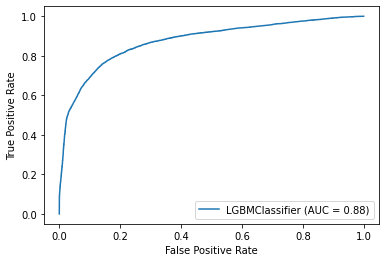

In [66]:
model_lgb = LGBMClassifier(random_state=100)
model_lgb.fit(X_train, y_train)

# prediction
y_pred_train_lgb = model_lgb.predict_proba(X_train)[:,1]
y_pred_test_lgb = model_lgb.predict_proba(X_test)[:,1]

plot_roc_curve(model_lgb, X_test, y_test)
print('Train roc auc score:', roc_auc_score(y_train, y_pred_train_lgb))
print('Test roc auc score:', roc_auc_score(y_test, y_pred_test_lgb))

Train roc auc score: 0.8937413953776461
Test roc auc score: 0.8744653894365212


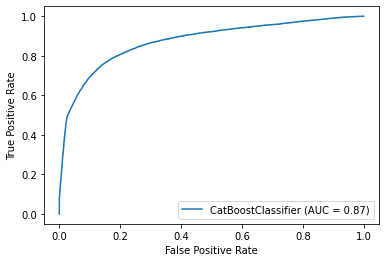

In [67]:
model_cat = CatBoostClassifier(random_state=100, verbose=0)

model_cat.fit(X_train, y_train)
# prediction
y_pred_train_cat = model_cat.predict_proba(X_train)[:,1]
y_pred_test_cat = model_cat.predict_proba(X_test)[:,1]

plot_roc_curve(model_cat, X_test, y_test)
print('Train roc auc score:', roc_auc_score(y_train, y_pred_train_cat))
print('Test roc auc score:', roc_auc_score(y_test, y_pred_test_cat))

Comments,
- Both LGB and CAT boosting models are performing good without overfitting.
- Both LGB and CAT boosting algorithms are giving high values for roc_auc values. We would try to create ensemble of these model in oder to avoid any overfitting issue and also to utilize learning from both of them. 

In [69]:
fin_tab = pd.DataFrame(zip(pd.read_csv('/content/gdrive/MyDrive/AV/test_mSzZ8RL.csv')['ID'], model_cat.predict_proba(X_t)[:,1], model_lgb.predict_proba(X_t)[:,1]),
            columns = ['ID', 'cat','lgb']) 

fin_tab.head()

,ID,cat,lgb
0,VBENBARO,0.045995,0.046973
1,CCMEWNKY,0.861414,0.854962
2,VK3KGA9M,0.041784,0.052473
3,TT8RPZVC,0.025248,0.025410
4,SHQZEYTZ,0.021324,0.024179


In [70]:
fin_tab['Is_Lead'] = (fin_tab.cat + fin_tab.lgb)/2
fin_tab

,ID,cat,lgb,Is_Lead
0,VBENBARO,0.045995,0.046973,0.046484
1,CCMEWNKY,0.861414,0.854962,0.858188
2,VK3KGA9M,0.041784,0.052473,0.047128
3,TT8RPZVC,0.025248,0.025410,0.025329
4,SHQZEYTZ,0.021324,0.024179,0.022752
...,...,...,...,...
105307,DBENJOYI,0.987335,0.989295,0.988315
105308,CWQ72DWS,0.681324,0.579426,0.630375
105309,HDESC8GU,0.090233,0.066042,0.078137
105310,2PW4SFCA,0.206384,0.200430,0.203407


Here, we would be using mean of both the LGB and CAT model outputs for submission purpose and check the overall performance.

In [71]:
fin_tab[['ID', 'Is_Lead']].to_csv('final_sub_AV.csv', index=False)

-------------------------------